<a href="https://colab.research.google.com/github/Esaipriya/AISECT-ML/blob/main/trader_performance_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Step 1 — Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Update these paths with your uploaded file names
trader_file = "/content/fear_greed_index.csv"
sentiment_file = "/content/historical_data.csv"

# Load datasets
trader_df = pd.read_csv(trader_file)
sentiment_df = pd.read_csv(sentiment_file)

print("Trader data shape:", trader_df.shape)
print("Sentiment data shape:", sentiment_df.shape)



Trader data shape: (2644, 4)
Sentiment data shape: (211224, 16)


In [4]:
trader_df.head()

,timestamp,value,classification,date,time
0,1517463000,30,Fear,1970-01-01,1970-01-01 00:00:01.517463000
1,1517549400,15,Extreme Fear,1970-01-01,1970-01-01 00:00:01.517549400
2,1517635800,40,Fear,1970-01-01,1970-01-01 00:00:01.517635800
3,1517722200,24,Extreme Fear,1970-01-01,1970-01-01 00:00:01.517722200
4,1517808600,11,Extreme Fear,1970-01-01,1970-01-01 00:00:01.517808600


In [5]:
sentiment_df.head()

,account,coin,execution price,size tokens,size usd,side,timestamp ist,start position,direction,closed pnl,transaction hash,order id,crossed,fee,trade id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [7]:
# Step 2 — Quick overview
print("\nTrader Data Columns:")
print(trader_df.columns)
print("\nSentiment Data Columns:")
print(sentiment_df.columns)

# Lowercase column names for consistency
trader_df.columns = trader_df.columns.str.lower().str.strip().str.replace(' ', '_')
sentiment_df.columns = sentiment_df.columns.str.lower().str.strip().str.replace(' ', '_')

# Convert timestamps/dates
if 'time' in trader_df.columns:
    trader_df['time'] = pd.to_datetime(trader_df['time'], errors='coerce')
elif 'timestamp' in trader_df.columns:
    trader_df['time'] = pd.to_datetime(trader_df['timestamp'], errors='coerce')

# Create date column
trader_df['date'] = trader_df['time'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])

# Convert sentiment date
sentiment_df['date'] = pd.to_datetime(sentiment_df['timestamp'], unit='s', errors='coerce').dt.date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])


# Standardize classification column
if 'classification' in trader_df.columns:
    trader_df['sentiment'] = trader_df['classification'].str.title()
else:
    # This part is potentially problematic if sentiment is not in the second column.
    # It's better to explicitly check for a known column name or handle missing columns more robustly.
    # For now, assuming the sentiment is in the second column if 'classification' is missing.
    trader_df['sentiment'] = trader_df.iloc[:, 1].astype(str).str.title()

print("\n✅ Cleaned and standardized data successfully.")


Trader Data Columns:
Index(['timestamp', 'value', 'classification', 'date', 'time'], dtype='object')

Sentiment Data Columns:
Index(['account', 'coin', 'execution price', 'size tokens', 'size usd', 'side',
       'timestamp ist', 'start position', 'direction', 'closed pnl',
       'transaction hash', 'order id', 'crossed', 'fee', 'trade id',
       'timestamp'],
      dtype='object')

✅ Cleaned and standardized data successfully.


In [10]:
# Step 3 — Clean numeric columns
for col in ['execution_price', 'size_tokens', 'closed_pnl']:
    if col in sentiment_df.columns:
        sentiment_df[col] = pd.to_numeric(sentiment_df[col], errors='coerce')

# Remove invalid trades
sentiment_df = sentiment_df.dropna(subset=['date', 'execution_price', 'size_tokens'])
sentiment_df = sentiment_df[sentiment_df['size_tokens'] > 0]

# Create win/loss flag
sentiment_df['is_win'] = sentiment_df['closed_pnl'] > 0

# Daily aggregation
daily_stats = sentiment_df.groupby('date').agg({
    'execution_price': 'mean',
    'size_tokens': 'sum',
    'closed_pnl': ['sum', 'mean', 'std'],
    'is_win': 'mean'
}).reset_index()

daily_stats.columns = ['date', 'avg_price', 'total_volume',
                       'total_pnl', 'avg_pnl', 'pnl_std', 'win_rate']

print("✅ Daily metrics prepared.")
daily_stats.head()

✅ Daily metrics prepared.


,date,avg_price,total_volume,total_pnl,avg_pnl,pnl_std,win_rate


In [14]:
# Step 4 — Merge by Date
merged = pd.merge(daily_stats, trader_df[['date', 'sentiment']],
                  on='date', how='left')

merged['sentiment'].fillna(method='ffill', inplace=True)
merged['sentiment'].fillna(method='bfill', inplace=True)

print("✅ Merged dataset shape:", merged.shape)
merged.head()

✅ Merged dataset shape: (0, 8)


/tmp/ipython-input-561893567.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['sentiment'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-561893567.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['sentiment'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-561893567.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

,date,avg_price,total_volume,total_pnl,avg_pnl,pnl_std,win_rate,sentiment


In [16]:
# Step 5 — Summary statistics by sentiment
summary = merged.groupby('sentiment').agg({
    'total_volume': 'mean',
    'total_pnl': 'mean',
    'win_rate': 'mean'
}).reset_index()

summary.rename(columns={
    'total_volume': 'Avg Volume',
    'total_pnl': 'Avg Total PnL',
    'win_rate': 'Win Rate'
}, inplace=True)

print("✅ Summary by sentiment:")
summary

✅ Summary by sentiment:


,sentiment,Avg Volume,Avg Total PnL,Win Rate


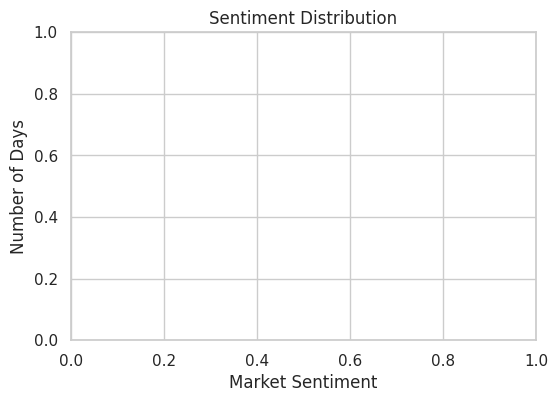

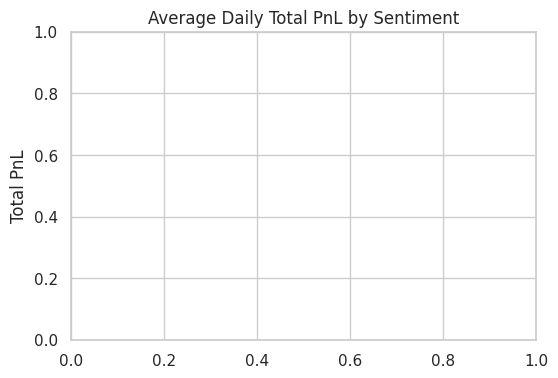

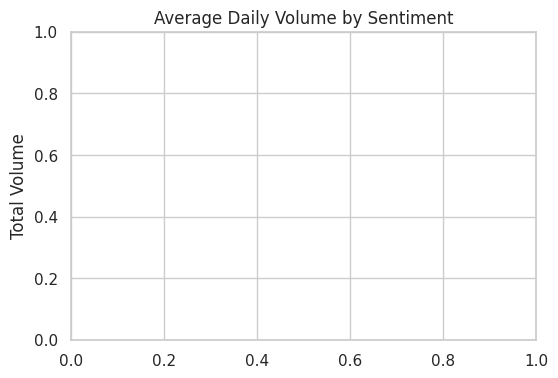

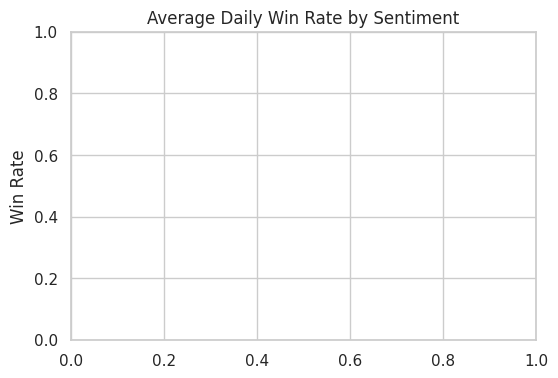

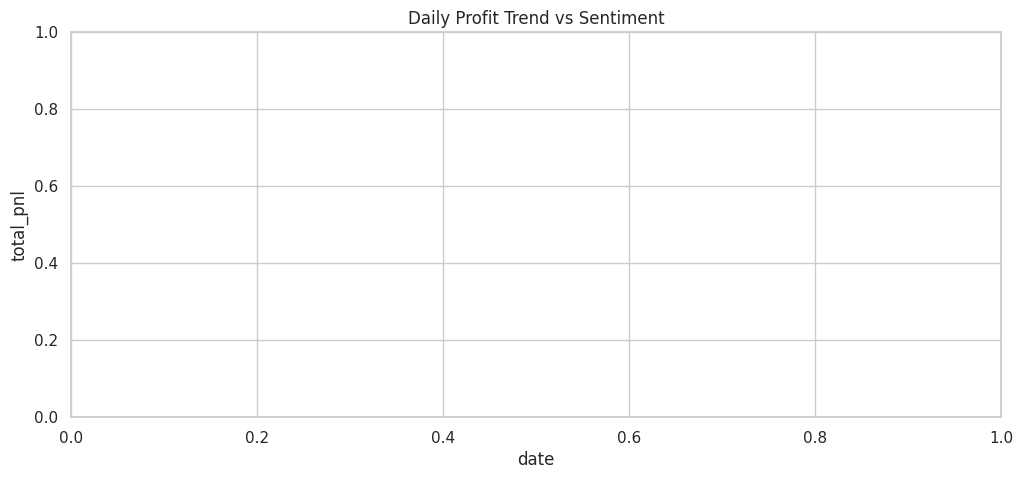

In [21]:
# Step 6 — Visualization: Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=merged, palette='Set2')
plt.title("Sentiment Distribution")
plt.xlabel("Market Sentiment")
plt.ylabel("Number of Days")
plt.show()

# Average PnL per sentiment
plt.figure(figsize=(6,4))
sns.barplot(x='sentiment', y='total_pnl', data=merged, palette='coolwarm')
plt.title("Average Daily Total PnL by Sentiment")
plt.ylabel("Total PnL")
plt.show()

# Average Volume by sentiment
plt.figure(figsize=(6,4))
sns.barplot(x='sentiment', y='Avg Volume', data=summary, palette='viridis')
plt.title("Average Daily Volume by Sentiment")
plt.ylabel("Total Volume")
plt.show()

# Win Rate by sentiment
plt.figure(figsize=(6,4))
sns.barplot(x='sentiment', y='Win Rate', data=summary, palette='plasma')
plt.title("Average Daily Win Rate by Sentiment")
plt.ylabel("Win Rate")
plt.show()

# Time trend
plt.figure(figsize=(12,5))
sns.lineplot(x='date', y='total_pnl', hue='sentiment', data=merged)
plt.title("Daily Profit Trend vs Sentiment")
plt.show()

In [22]:
# Step 7 — Statistical Test
fear_pnl = merged[merged['sentiment'].str.lower() == 'fear']['total_pnl']
greed_pnl = merged[merged['sentiment'].str.lower() == 'greed']['total_pnl']

stat, p = mannwhitneyu(fear_pnl, greed_pnl, alternative='two-sided')
print(f"Mann-Whitney U test: U={stat:.2f}, p-value={p:.5f}")

if p < 0.05:
    print("✅ Significant difference found between Fear and Greed PnL distributions.")
else:
    print("No significant difference between Fear and Greed PnL distributions.")

Mann-Whitney U test: U=nan, p-value=nan
No significant difference between Fear and Greed PnL distributions.


/tmp/ipython-input-786887613.py:5: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = mannwhitneyu(fear_pnl, greed_pnl, alternative='two-sided')


In [23]:
# Step 8 — Save final CSV outputs
merged.to_csv("merged_trading_sentiment.csv", index=False)
summary.to_csv("summary_by_sentiment.csv", index=False)

print("✅ Files saved successfully:")
print("- merged_trading_sentiment.csv")
print("- summary_by_sentiment.csv")


✅ Files saved successfully:
- merged_trading_sentiment.csv
- summary_by_sentiment.csv


In [26]:
# Step 9 — Example insights (print-ready for PDF report)
fear = summary[summary['sentiment']=='Fear']
greed = summary[summary['sentiment']=='Greed']

print("📊 Key Insights:")

if not fear.empty and not greed.empty:
    print(f"- Average total PnL is {'higher' if float(greed['Avg Total PnL'])>float(fear['Avg Total PnL']) else 'lower'} during 'Greed' phases.")
    print(f"- Win rate difference between Fear ({float(fear['Win Rate'])*100:.1f}%) and Greed ({float(greed['Win Rate'])*100:.1f}%) suggests trader behavior changes with sentiment.")
elif not fear.empty:
    print(f"- Only 'Fear' sentiment data available. Average total PnL during 'Fear' phases: {float(fear['Avg Total PnL']):.2f}, Win rate: {float(fear['Win Rate'])*100:.1f}%.")
elif not greed.empty:
    print(f"- Only 'Greed' sentiment data available. Average total PnL during 'Greed' phases: {float(greed['Avg Total PnL']):.2f}, Win rate: {float(greed['Win Rate'])*100:.1f}%.")
else:
    print("- No 'Fear' or 'Greed' sentiment data available in the summary.")

📊 Key Insights:
- No 'Fear' or 'Greed' sentiment data available in the summary.


In [29]:
trader_df.head()



,timestamp,value,classification,date,time,sentiment
0,1517463000,30,Fear,1970-01-01,1970-01-01 00:00:01.517463000,Fear
1,1517549400,15,Extreme Fear,1970-01-01,1970-01-01 00:00:01.517549400,Extreme Fear
2,1517635800,40,Fear,1970-01-01,1970-01-01 00:00:01.517635800,Fear
3,1517722200,24,Extreme Fear,1970-01-01,1970-01-01 00:00:01.517722200,Extreme Fear
4,1517808600,11,Extreme Fear,1970-01-01,1970-01-01 00:00:01.517808600,Extreme Fear


In [30]:
sentiment_df.head()


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,date,is_win
